# A2 Bias In Data

## TL;DR   
The purpose of this exploration is to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.  Specifically, this analysis attempts to answer the question, _"How consistent are the labeling behaviors among workers with different demographic profiles?"_ in regards to  two separate Wikimedia datasets:  
1. Toxicity
2. Aggression


__RELATED LINKS:__   
_Data Source:  https://figshare.com/projects/Wikipedia_Talk/16731_  
_Overview of the project:  https://meta.wikimedia.org/wiki/Research:Detox_  
_Overview of the data: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release_

---

## DATA AQUISITION

The code below will download all the data needed in this analysis, using the `%%caption` magic keyword to suppress the outputs.

In [1]:
%%capture  

# download toxicity data
!wget https://ndownloader.figshare.com/files/7394539 -O Raw_Data/toxicity_annotations.tsv
!wget https://ndownloader.figshare.com/files/7394542 -O Raw_Data/toxicity_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640581 -O Raw_Data/toxicity_worker_demographics.tsv

# download aggression data
!wget https://ndownloader.figshare.com/files/7394506 -O Raw_Data/aggression_annotations.tsv
!wget https://ndownloader.figshare.com/files/7038038 -O Raw_Data/aggression_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640644 -O Raw_Data/aggression_worker_demographics.tsv
     
# downlaod personal attacks
!wget https://ndownloader.figshare.com/files/7554637 -O Raw_Data/attack_annotations.tsv
!wget https://ndownloader.figshare.com/files/7554634 -O Raw_Data/attack_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640752 -O Raw_Data/attack_worker_demographics.tsv


The code below will transform the downloaded data into a pandas dataframe.

In [39]:
import pandas as pd

# toxicity data
toxicity_annotations = pd.read_csv("Raw_Data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("Raw_Data/toxicity_annotated_comments.tsv", delimiter="\t", index_col=0)
toxicity_worker_demographics = pd.read_csv("Raw_Data/toxicity_worker_demographics.tsv", delimiter="\t")

# aggression data
aggression_annotations = pd.read_csv("Raw_Data/aggression_annotations.tsv", delimiter="\t")
aggression_annotated_comments = pd.read_csv("Raw_Data/aggression_annotated_comments.tsv", delimiter="\t", index_col=0)
aggression_worker_demographics = pd.read_csv("Raw_Data/aggression_worker_demographics.tsv", delimiter="\t")

# personal attack data
attack_annotations = pd.read_csv("Raw_Data/attack_annotations.tsv", delimiter="\t")
attack_annotated_comments = pd.read_csv("Raw_Data/attack_annotated_comments.tsv", delimiter="\t", index_col=0)
attack_worker_demographics = pd.read_csv("Raw_Data/attack_worker_demographics.tsv", delimiter="\t")

## BIAS IN THE TOXICITY DATA SET

### INITIAL EDA

From the documentation we know there are 160k labeled comments in the Toxicity dataset.  First, let's look at the demographic distribution for the labelers in the toxicity dataset by building a few simple bar plots.

In [40]:
# import libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# magic code for viewing plots using jupyter notebooks:
%matplotlib inline 

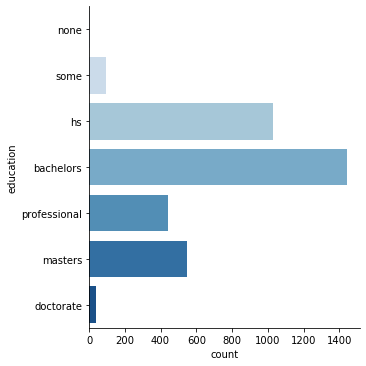

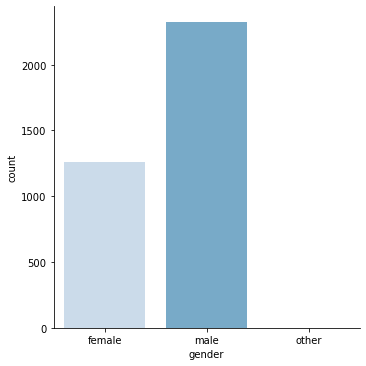

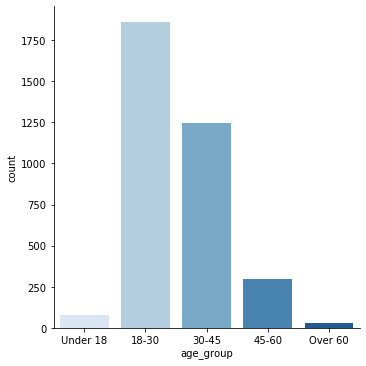

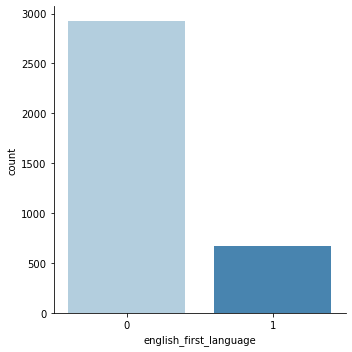

In [41]:
# plot education distribution
sns.catplot(y="education", 
            kind="count", 
            data=toxicity_worker_demographics,
            order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
            palette=("Blues"))

# plot gender dist
sns.catplot(x="gender", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues"))

# plot age group dist
sns.catplot(x="age_group", 
            kind="count", 
            data=toxicity_worker_demographics,
            order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
            palette=("Blues"))

# plot language dist
sns.catplot(x="english_first_language", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues"))

plt.tight_layout()

Immediately, it's clear there is quite a lot of skewed data in the demographics.  The following results become immediately apparent:
* Even though this is from english wikipedia, the vast majority of labelers are non-native English speakers.
* The majority of labelers are in the 18-30 age range.
* The majority of labelers are male.
* The majority of labelers hold a bachelors degree. 

We can combine some of this information to look for additional potential bias:

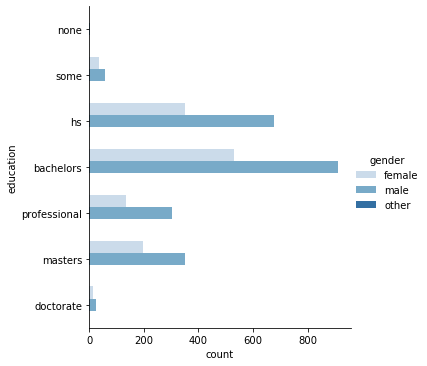

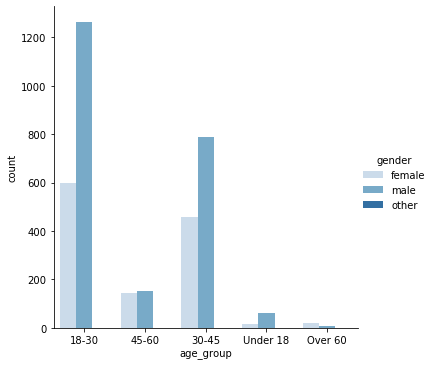

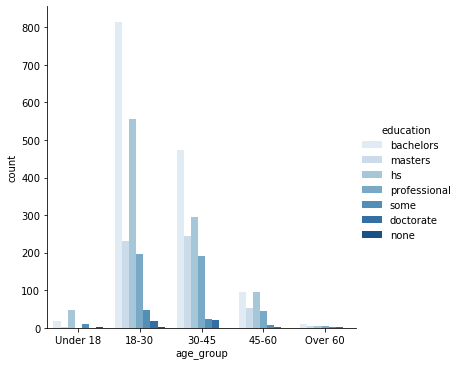

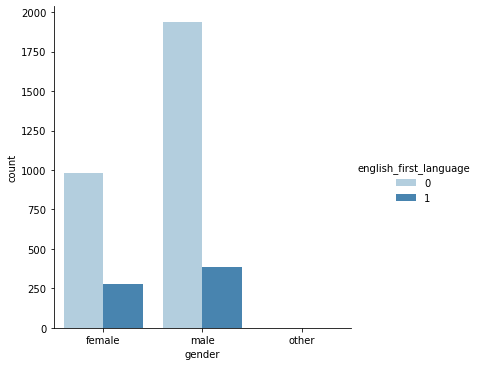

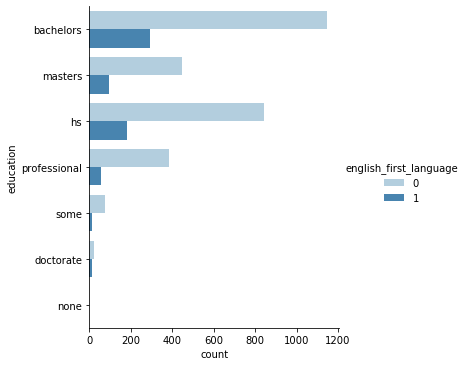

In [42]:
# plot education v. gender
sns.catplot(y="education", 
            kind="count", 
            hue = 'gender',
            data=toxicity_worker_demographics,
            order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
            palette=("Blues"))

# plot gender v. age
sns.catplot(x="age_group", 
            kind="count",
            hue = 'gender',
            data=toxicity_worker_demographics,
            palette=("Blues"))

# plot age v. education
sns.catplot(x="age_group", 
            kind="count",
            hue = 'education',
            data=toxicity_worker_demographics,
            order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
            palette=("Blues"))

# plot language v. gender
sns.catplot(x="gender", 
            kind="count", 
            hue = 'english_first_language',
            data=toxicity_worker_demographics,
            palette=("Blues"))

# plot language v. education
sns.catplot(y="education", 
            kind="count", 
            hue = 'english_first_language',
            data=toxicity_worker_demographics,
            palette=("Blues"))

There is clearly a lot of bias towards non-native english speaking males with a bachelor's degree in the 18-30 age group.   One interesting result here is that although there are significantly more men in the overall group, the _Over 60_ age group is biased in favor of women.  Next, we will examine the types of columns that typically get labeled as toxic.   We'll consider a comment to be toxic if at least 50% of reviewers labeled it as such.

In [43]:
# labels a comment as toxic if the majority of annotators did so
toxicity_labels = toxicity_annotations.groupby('rev_id')['toxicity'].mean() > 0.5

# join the labels and comments
toxicity_annotated_comments['labeled_toxic'] = toxicity_labels

# remove newline and tab tokens
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

If we preview the results we can verify that these comments indeed appear to be toxic.

In [45]:
# preview the results
toxicity_annotated_comments.loc[toxicity_annotated_comments['labeled_toxic'] == True].head(10)

,comment,year,logged_in,ns,sample,split,labeled_toxic
rev_id,,,,,,,
597212.0,"` After the wasted bit on his sexuality, I ha...",2003,False,article,random,test,True
1266286.0,"Erik, for crying out loud. You legally can...",2003,True,user,random,test,True
1502668.0,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",2003,True,user,blocked,test,True
2187425.0,```Nazi filth`` is impolite `,2004,True,article,random,train,True
3129678.0,"Prior to Quickpolls, he would have been perma...",2004,True,user,random,train,True
3427333.0,"Hi. Yes, I'd noticed. It's always gratifing to...",2004,True,user,random,train,True
3803199.0,"Yep, Shiguy. That's me. David Hodges. I have n...",2004,True,user,random,train,True
4282271.0,Better believe it. At least I earned a Barn...,2004,True,user,random,train,True
4632658.0,"i have a dick, its bigger than yours! hahaha",2004,False,article,blocked,train,True


We can quickly look for common words contained in these toxic comments.

In [48]:
# create a list of the 200 most common words in the comments
from collections import Counter
wordlist = Counter(" ".join(toxicity_annotated_comments.loc[toxicity_annotated_comments['labeled_toxic'] == True]['comment'].str.lower()).split()).most_common(75)

# remove common stop words from the list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

# add a few extra words to the stop word list
stopword_list |= set(['==', '-', '`', "I'm", 'wikipedia', 'wiki', '====', '.', 'me', 'im', 'hi'])

# print the final result
for item in wordlist:
    if item[0] not in stopword_list:
        print(item)

('fuck', 8284)
('nigger', 3937)
('like', 3377)
('fucking', 3166)
('suck', 3080)
('go', 2753)
('shit', 2687)
('hate', 2586)
('u', 2528)
('faggot', 2454)
('get', 2271)
('know', 2016)
('fat', 1937)
('die', 1803)
('gay', 1767)
('moron', 1691)
('ass', 1605)
('people', 1574)
("i'm", 1428)
('pig', 1299)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The results are not particulary surprising.    This is the sort of langauge I would expect to find in toxic comments.   With few exceptions, most of these words do not have an alternate definitions. In search of bias, we can examine how these comments were treated by the labelers based on on demographic breakdowns.

### ANALYSIS

The analysis below attempts to answer the question, "How consistent are the toxicity labeling behaviors among workers with different demographic profiles?  

Since the data is divided into three separate files, it must be joined in various ways in order to analyze.

In [9]:
# join demographics to annotations
joined_toxicity_demographics = toxicity_annotations.join(toxicity_worker_demographics, on="worker_id", rsuffix="_r")

# join comments to annotations
joined_toxicity_comments = toxicity_annotations.join(toxicity_annotated_comments, on="rev_id", rsuffix="_r")

Quickly previewing the results of each table:

In [10]:
display(joined_toxicity_demographics.head(3))
display(joined_toxicity_comments.head(3))

,rev_id,worker_id,toxicity,toxicity_score,worker_id_r,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,1789.0,male,1.0,30-45,bachelors
1,2232.0,4000,0,0.0,NaN,NaN,NaN,NaN,NaN
2,2232.0,3989,0,1.0,NaN,NaN,NaN,NaN,NaN


,rev_id,worker_id,toxicity,toxicity_score,comment,year,logged_in,ns,sample,split,labeled_toxic
0,2232.0,723,0,0.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False
1,2232.0,4000,0,0.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False
2,2232.0,3989,0,1.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False


We can calculate a mean toxicity score for each individual and add that to the demographics table.

In [11]:
# calculate average toxicity per user
avg_worker_toxicity = joined_toxicity_demographics.groupby("worker_id")["toxicity_score"].mean()

# join the average toxicity to the demographics table
toxicity_worker_demographics = toxicity_worker_demographics.join( avg_worker_toxicity )

# preview the results
toxicity_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education,toxicity_score
0,85,female,0,18-30,bachelors,-0.208768
1,1617,female,0,45-60,bachelors,0.000000
2,1394,female,0,NaN,bachelors,0.258403
3,311,male,0,30-45,bachelors,0.689373
4,1980,male,0,45-60,masters,-0.105263


There is quite a lot of bias in the toxicity score by age group.   This becomes more apparent in graph form.   There is appears to be a direct linear relationship between age and the average toxicity score.

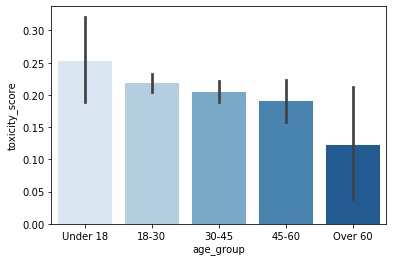

In [12]:
# create barplot, specify the order
sns.barplot(x="age_group", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
                palette=("Blues"))

However, the scoring is much more uniform across the other demographic groups (education, language, and gender).   

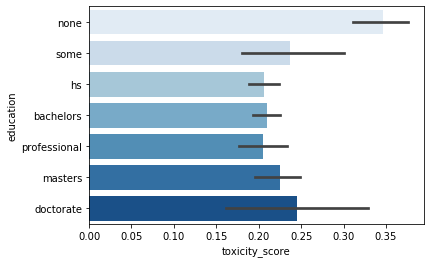

In [13]:
# create barplot, specify the order
sns.barplot(y="education", 
                 x="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
                 palette=("Blues"))

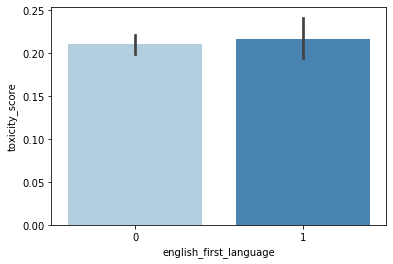

In [14]:
# create barplot, specify the order
sns.barplot(x="english_first_language", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 palette=("Blues"))

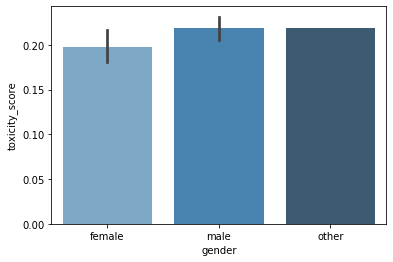

In [15]:
# create barplot, specify the order
sns.barplot(x="gender", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 palette=("Blues_d"))

The most dramatic difference in scoring appears to be from individuals in the over 60 group.  Males over 60 appear to have a wide range of opinions on terms of scoring.

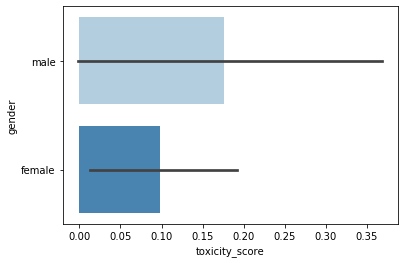

In [16]:
sns.barplot(x="toxicity_score", 
                 y="gender", 
                 data=toxicity_worker_demographics.loc[toxicity_worker_demographics['age_group'] == "Over 60"], 
                 palette=("Blues"))

Now, we can calculate the average toxicity score per comment.   We can see which demographics differ from the mean score in the most dramatic ways.

In [17]:
# calculate average toxicity per rev_id
avg_rev_toxicity = joined_toxicity_demographics.groupby("rev_id")["toxicity_score"].mean()

# joined the average toxicity per rev to the dataframe
joined_toxicity_demographics = joined_toxicity_demographics.join(avg_rev_toxicity, on="rev_id", rsuffix="_r")

# calculate the user's difference from the mean
joined_toxicity_demographics["dif_from_mean"] = joined_toxicity_demographics['toxicity_score'] - joined_toxicity_demographics['toxicity_score_r']

# preview results
joined_toxicity_demographics

,rev_id,worker_id,toxicity,toxicity_score,worker_id_r,gender,english_first_language,age_group,education,toxicity_score_r,dif_from_mean
0,2232.0,723,0,0.0,1789.0,male,1.0,30-45,bachelors,0.4,-0.4
1,2232.0,4000,0,0.0,NaN,NaN,NaN,NaN,NaN,0.4,-0.4
2,2232.0,3989,0,1.0,NaN,NaN,NaN,NaN,NaN,0.4,0.6
3,2232.0,3341,0,0.0,3974.0,male,0.0,18-30,hs,0.4,-0.4
4,2232.0,1574,0,1.0,3863.0,female,0.0,18-30,professional,0.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...
1598284,699897151.0,1550,0,0.0,368.0,female,0.0,18-30,hs,0.4,-0.4
1598285,699897151.0,1025,0,1.0,1086.0,male,0.0,45-60,bachelors,0.4,0.6
1598286,699897151.0,648,0,1.0,387.0,male,0.0,18-30,hs,0.4,0.6
1598287,699897151.0,379,0,0.0,3100.0,female,1.0,18-30,bachelors,0.4,-0.4


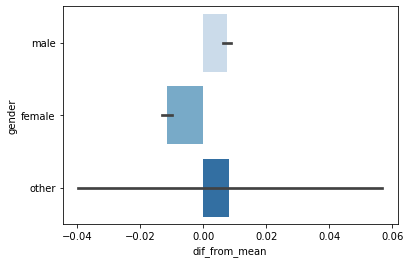

In [18]:
sns.barplot(x="dif_from_mean", 
                 y="gender", 
                 data=joined_toxicity_demographics, 
                 palette=("Blues"))

In general, it appears that men have a tendency to rate comments as slightly more toxic than women.  Looking at the age groups produces an even more startling result.  Users over 60 deviate dramatically from the average toxicity score.   Clearly, in this group there appears to be much less sensitivity towards toxic comments.

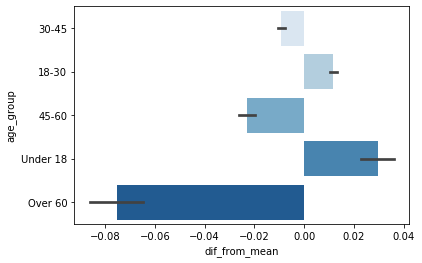

In [19]:
sns.barplot(x="dif_from_mean", 
                 y="age_group", 
                 data=joined_toxicity_demographics, 
                 palette=("Blues"))

## BIAS IN THE AGGRESSION DATASET

### INITIAL EDA

There are about 100k labeled comments in the `aggression` data set.  We can repeat a similar analysis here.

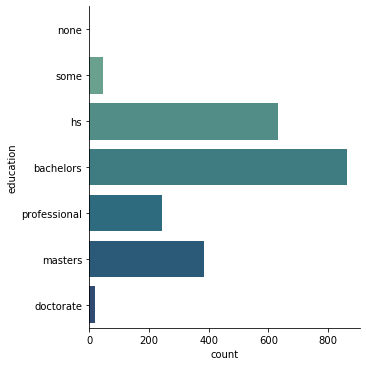

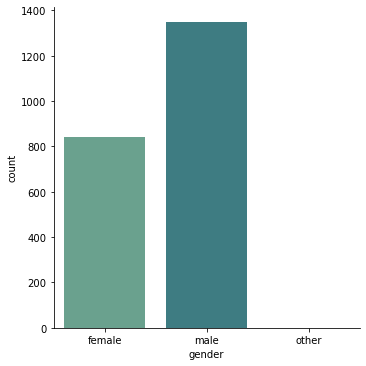

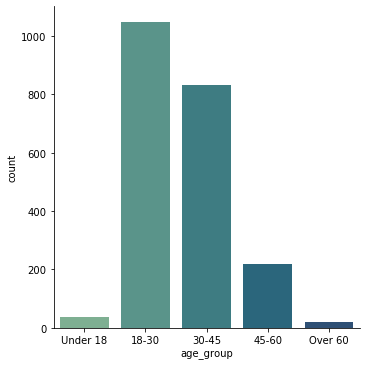

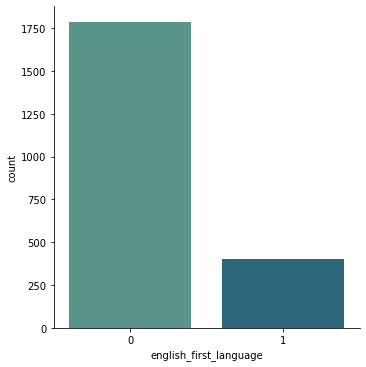

In [20]:
# plot education distribution
sns.catplot(y="education", 
            kind="count", 
            data=aggression_worker_demographics,
            order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
            palette=("crest"))

# plot gender dist
sns.catplot(x="gender", 
            kind="count", 
            data=aggression_worker_demographics,
            palette=("crest"))

# plot age group dist
sns.catplot(x="age_group", 
            kind="count", 
            data=aggression_worker_demographics,
            order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
            palette=("crest"))

# plot language dist
sns.catplot(x="english_first_language", 
            kind="count", 
            data=aggression_worker_demographics,
            palette=("crest"))


Here again, we see similiar issues to the toxicity dataset.   It appears as though this is a very similiar group of individuals was responsible for categorizing these comments as well.   We will again examine the types of columns that typically get labeled as aggressive.   We'll consider a comment to be toxic if at least 50% of reviewers labeled it as such.

In [21]:
# labels a comment as toxic if the majority of annotators did so
aggression_labels = aggression_annotations.groupby('rev_id')['aggression'].mean() > 0.5

# join the labels and comments
aggression_annotated_comments['labeled_aggression'] = aggression_labels

# remove newline and tab tokens
aggression_annotated_comments['comment'] = aggression_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
aggression_annotated_comments['comment'] = aggression_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [22]:
# preview the results
aggression_annotated_comments.loc[aggression_annotated_comments['labeled_aggression'] == True].head(15)

,comment,year,logged_in,ns,sample,split,labeled_aggression
rev_id,,,,,,,
694840,` :Click on my ``Annoying Users`` link! I gue...,2003,True,user,random,train,True
801279,Iraq is not good === === USA is bad,2003,True,article,random,train,True
1450441,` Buddha - ``Some suggest that victims should...,2003,True,article,random,train,True
2702703,____ fuck off you little asshole. If you wan...,2004,True,user,random,train,True
4632658,"i have a dick, its bigger than yours! hahaha",2004,True,article,blocked,train,True
6201487,:get the damn chronology correct. I don't t...,2004,True,user,random,train,True
6545332,== renault == you sad little bpy for drivin...,2004,True,user,blocked,train,True
6545351,== renault == you sad little bo for driving...,2004,True,user,blocked,test,True
7977970,"34, 30 Nov 2004 (UTC) ::Because you like to a...",2004,True,article,random,train,True


The tone of these comments appears to be very similiar to the toxic comments.   It doesn't seem as though there will be a lot of value to be gained from running a keyword analysis against this dataset for EDA as language is quite simliar.  Instead, we will move on to the analysis.

### AGGRESSION ANALYSIS

The analysis below attempts to answer the question, "How consistent are the aggression labeling behaviors among workers with different demographic profiles?  

Again, we will start by joining the data files.

In [23]:
# join demographics to annotations
joined_aggression_demographics = aggression_annotations.join(aggression_worker_demographics, on="worker_id", rsuffix="_r")

# join comments to annotations
joined_aggression_comments = aggression_annotations.join(aggression_annotated_comments, on="rev_id", rsuffix="_r")

# preview the results of each table
display(joined_aggression_demographics.head(3))
display(joined_aggression_comments.head(3))

,rev_id,worker_id,aggression,aggression_score,worker_id_r,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,3248.0,male,0.0,30-45,bachelors
1,37675,2408,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,37675,1493,0.0,0.0,2953.0,female,0.0,30-45,hs


,rev_id,worker_id,aggression,aggression_score,comment,year,logged_in,ns,sample,split,labeled_aggression
0,37675,1362,1.0,-1.0,`- This is not ``creative``. Those are the di...,2002,True,article,random,train,False
1,37675,2408,0.0,1.0,`- This is not ``creative``. Those are the di...,2002,True,article,random,train,False
2,37675,1493,0.0,0.0,`- This is not ``creative``. Those are the di...,2002,True,article,random,train,False


In [24]:
# calculate average attack score per user
avg_worker_aggression = joined_aggression_demographics.groupby("worker_id")["aggression_score"].mean()

# join the average toxicity to the demographics table
aggression_worker_demographics = aggression_worker_demographics.join( avg_worker_aggression )

# preview the results
aggression_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education,aggression_score
0,833,female,0,45-60,bachelors,-0.461388
1,1072,male,0,30-45,bachelors,-0.092138
2,872,male,0,18-30,hs,0.000000
3,2116,male,0,30-45,professional,-0.050242
4,453,male,0,30-45,hs,-0.233405


We can now look at the average aggression score, broken down by demographic.   For this dataset, the signs have switched, meaning positive numbers are friendly and negative numbers indicate an aggressive comment.

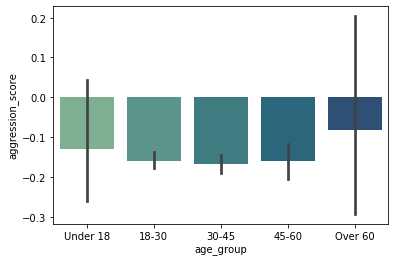

In [25]:
# create barplot, specify the order
sns.barplot(x="age_group", 
                 y="aggression_score", 
                 data=aggression_worker_demographics, 
                 order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
                palette=("crest"))

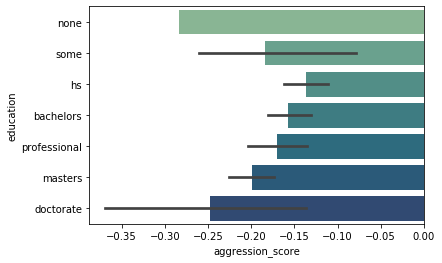

In [26]:
sns.barplot(y="education", 
                 x="aggression_score", 
                 data=aggression_worker_demographics, 
                 order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
                 palette=("crest"))

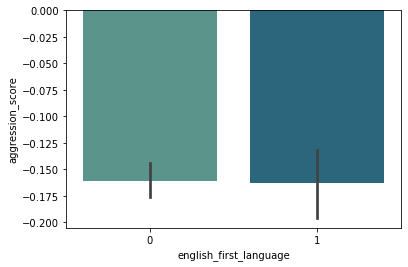

In [27]:
# create barplot, specify the order
sns.barplot(x="english_first_language", 
                 y="aggression_score", 
                 data=aggression_worker_demographics, 
                 palette=("crest"))

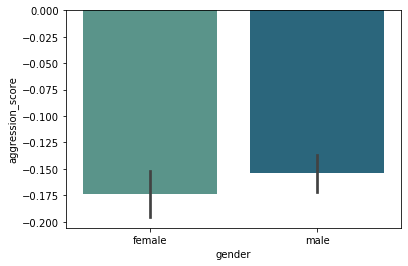

In [28]:
# create barplot, specify the order
sns.barplot(x="gender", 
                 y="aggression_score", 
                 data=aggression_worker_demographics.loc[aggression_worker_demographics['gender'].isin(['female', 'male'])], 
                 palette=("crest"))

These results look much more uniform than the toxicity dataset.   Most groups appear to have a similar scoring averages.  Again, let's calculate the average aggression score per comment in an attempt to see which demographic groups differ the most from the mean score.

In [29]:
# calculate average toxicity per rev_id
avg_rev_aggression = joined_aggression_demographics.groupby("rev_id")["aggression_score"].mean()

# joined the average toxicity per rev to the dataframe
joined_aggression_demographics = joined_aggression_demographics.join(avg_rev_aggression, on="rev_id", rsuffix="_r")

# calculate the user's difference from the mean
joined_aggression_demographics["dif_from_mean"] = joined_aggression_demographics['aggression_score'] - joined_aggression_demographics['aggression_score_r']

# preview results
joined_aggression_demographics

If we break this down by education we can see a large difference in the scoring of those with no education.

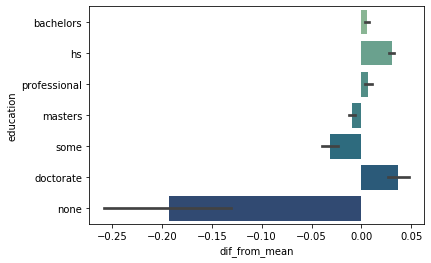

In [35]:
sns.barplot(x="dif_from_mean", 
                 y="education", 
                 data=joined_aggression_demographics, 
                 palette=("crest"))

When we look at the difference in scoring across age groups, the result is quite alarming.   There is very little consensus among teenagers and senior citizens when it comes to labeling an aggressive comment.  On average, labelers under 18 tend to view comments as more aggressive, while those over 60 tend to view comments as less aggressive.

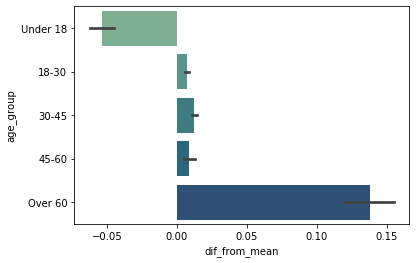

In [33]:
sns.barplot(x="dif_from_mean", 
                 y="age_group", 
                 data=joined_aggression_demographics, 
                 order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
                 palette=("crest"))

## SUMMARY OF RESULTS

For both datasets examined in this notebook, the largest demographic factor in relation to labeling behavior was age.   Users in the _Under 18_ age group consistently labeled comments in a different way than the _Over 60_ group.  If a single comment was examined by 10 users in the _Over 60_ age group, they would be significantly more likely to label it friendly and non-toxic.   The opposite would be true if the 10 labelers were replaced with teenagers.  Since flagging comments is a classification problem requiring a binary designation, this lack of consesus should be handled carefully when attempting to machine learning models.

## IMPLICATIONS

Review the demo applications listed in the “Perspective Hacks (Links to an external site.)” gallery. Based on what you now know about the Wikipedia Talk corpus from the analysis you just performed, answer at least 3 of the following questions (use complete sentences. At least 2-3 sentences per answer).

When answering these questions, consider the intended purpose of the demo application—what problem is it intended to solve? What activity is it supposed to support?

Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?
Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?
What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?
What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 
What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?
Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

### 